<a href="https://colab.research.google.com/github/DrLux/Berkeley_Deep_RL/blob/master/Homework2/HW2_policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Spiegazione di REINFORCE:](https://docs.google.com/document/d/1z5oPtWuwRzEHxjtzsZqEjbPdWZv9uLj8nR1DCvQd-rI/edit?usp=sharing) 


[This is my solution of  homework2 from CS 294-112 at UC Berkeley:](http://rail.eecs.berkeley.edu/deeprlcourse/static/homeworks/hw2.pdf) 


In [0]:
# @title Clear data in current folder
!rm -r checkpoint
!rm -r data
!rm -r video

In [0]:
# @title Install all dependencies.
!pip install roboschool
!sudo apt-get install xvfb
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [0]:
# @title Load functions for plotting (plot.py)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

def plot_data(data, value="AverageReturn"):
    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)

    sns.set(style="darkgrid", font_scale=1.5)
    sns.tsplot(data=data, time="Iteration", value=value, unit="Unit", condition="Condition")
    plt.legend(loc='best').draggable()
    plt.show()


def get_datasets(fpath, condition=None):
    unit = 0
    datasets = []
    for root, dir, files in os.walk(fpath):
        if 'log.txt' in files:
            param_path = open(os.path.join(root,'params.json'))
            params = json.load(param_path)
            exp_name = params['exp_name']
            
            log_path = os.path.join(root,'log.txt')
            experiment_data = pd.read_table(log_path)

            experiment_data.insert(
                len(experiment_data.columns),
                'Unit',
                unit
                )        
            experiment_data.insert(
                len(experiment_data.columns),
                'Condition',
                condition or exp_name
                )

            datasets.append(experiment_data)
            unit += 1

    return datasets

In [0]:
# @title Load functions for loggin data (logz.py)
import json

"""

Some simple logging functionality, inspired by rllab's logging.
Assumes that each diagnostic gets logged each iteration

Call logz.configure_output_dir() to start logging to a 
tab-separated-values file (some_folder_name/log.txt)

To load the learning curves, you can do, for example

A = np.genfromtxt('/tmp/expt_1468984536/log.txt',delimiter='\t',dtype=None, names=True)
A['EpRewMean']

"""

import os.path as osp, shutil, time, atexit, os, subprocess
import pickle
import tensorflow as tf

color2num = dict(
    gray=30,
    red=31,
    green=32,
    yellow=33,
    blue=34,
    magenta=35,
    cyan=36,
    white=37,
    crimson=38
)

def colorize(string, color, bold=False, highlight=False):
    attr = []
    num = color2num[color]
    if highlight: num += 10
    attr.append(str(num))
    if bold: attr.append('1')
    return '\x1b[%sm%s\x1b[0m' % (';'.join(attr), string)

class G:
    output_dir = None
    output_file = None
    first_row = True
    log_headers = []
    log_current_row = {}

def configure_output_dir(d=None):
    """
    Set output directory to d, or to /tmp/somerandomnumber if d is None
    """
    G.output_dir = d or "/tmp/experiments/%i"%int(time.time())
    assert not osp.exists(G.output_dir), "Log dir %s already exists! Delete it first or use a different dir"%G.output_dir
    os.makedirs(G.output_dir)
    G.output_file = open(osp.join(G.output_dir, "log.txt"), 'w')
    atexit.register(G.output_file.close)
    print(colorize("Logging data to %s"%G.output_file.name, 'green', bold=True))

def log_tabular(key, val):
    """
    Log a value of some diagnostic
    Call this once for each diagnostic quantity, each iteration
    """
    if G.first_row:
        G.log_headers.append(key)
    else:
        assert key in G.log_headers, "Trying to introduce a new key %s that you didn't include in the first iteration"%key
    assert key not in G.log_current_row, "You already set %s this iteration. Maybe you forgot to call dump_tabular()"%key
    G.log_current_row[key] = val

def save_params(params):
    with open(osp.join(G.output_dir, "params.json"), 'w') as out:
        out.write(json.dumps(params, separators=(',\n','\t:\t'), sort_keys=True))

def pickle_tf_vars():  
    """
    Saves tensorflow variables
    Requires them to be initialized first, also a default session must exist
    """
    _dict = {v.name : v.eval() for v in tf.global_variables()}
    with open(osp.join(G.output_dir, "vars.pkl"), 'wb') as f:
        pickle.dump(_dict, f)
    

def dump_tabular():
    """
    Write all of the diagnostics from the current iteration
    """
    vals = []
    key_lens = [len(key) for key in G.log_headers]
    max_key_len = max(15,max(key_lens))
    keystr = '%'+'%d'%max_key_len
    fmt = "| " + keystr + "s | %15s |"
    n_slashes = 22 + max_key_len
    print("-"*n_slashes)
    for key in G.log_headers:
        val = G.log_current_row.get(key, "")
        if hasattr(val, "__float__"): valstr = "%8.3g"%val
        else: valstr = val
        print(fmt%(key, valstr))
        vals.append(val)
    print("-"*n_slashes)
    if G.output_file is not None:
        if G.first_row:
            G.output_file.write("\t".join(G.log_headers))
            G.output_file.write("\n")
        G.output_file.write("\t".join(map(str,vals)))
        G.output_file.write("\n")
        G.output_file.flush()
    G.log_current_row.clear()
    G.first_row=False

In [0]:
# @title Import all dependencies.

import numpy as np
import tensorflow as tf
import gym
import scipy.signal
import os
import time
import inspect
from multiprocessing import Process
import tensorflow_probability as tfp
import roboschool
import io

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
from gym import wrappers
from gym.wrappers import Monitor
import base64

data/inverted_pendulum_RoboschoolInvertedPendulum-v1_01-06-2019_19-44-51
Logging data to data/inverted_pendulum_RoboschoolInvertedPendulum-v1_01-06-2019_19-44-51/1/log.txt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
********** Iteration 0 ************
----------------------------------------
|               Time |            28.3 |
|          Iteration |               0 |
|      AverageReturn |            17.2 |
|          StdReturn |            7.59 |
|          MaxReturn |              78 |
|          MinReturn |               6 |
|          EpLenMean |            17.2 |
|           EpLenStd |            7.59 |
| TimestepsThisBatch |         4.5e+04 |
|     TimestepsSoFar |         4.5e+04 |
----------------------------------------
********** Iteration 1 ************
----------------------------------------
|               Time |            55.2 |
|          Iteration |               1 |
|      AverageReturn |            19.5 |
|          StdReturn |            9.15 |
|   

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


Total reward of this episode:  1000.0


data/inverted_pendulum_RoboschoolInvertedPendulum-v1_01-06-2019_19-44-51/1/


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:1196: MatplotlibDeprecationWarning: 
Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.
  message="Legend.draggable() is drepecated in "


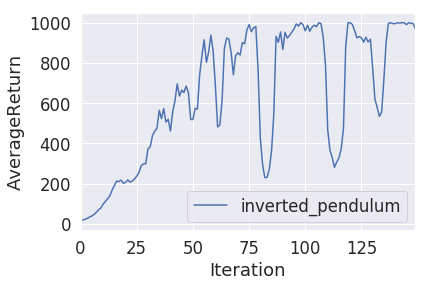

In [0]:
def init_arguments():
  arg = dict()
  arg['min_timesteps_per_batch']=45000 #-b
  arg['learning_rate']= 0.0025 #-lr

  arg['env_name']="RoboschoolInvertedPendulum-v1"
  arg['n_iter']= 150 #-n
  arg['n_experiments']=1 #-e
  arg['reward_to_go']=True #rtg
  arg['exp_name']="inverted_pendulum" #--exp_name
  
  arg['folder_to_checkpoint']="checkpoint"
  arg['path_to_video']="video"
  arg['seed']=1 #--seed
  arg['ep_len']=1000. #-ep  len max of each episode
  arg['gamma']=0.95 #--discount
  arg['animate']=False #--render
  arg['normalize_advantages']=True #-dna
  arg['nn_baseline']=True #-bl 
  arg['seed']=1 #--seed
  arg['n_layers']=2 #-l
  arg['size']=64 #-s
  arg['logdir'] = arg['exp_name'] + '_' + arg['env_name'] + '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
  arg['logdir'] = os.path.join('data', arg['logdir'])
  if not(os.path.exists(arg['logdir'])):
      os.makedirs(arg['logdir'])
  
  print(arg['logdir'])
  arg['max_path_length'] = arg['ep_len'] if arg['ep_len'] > 0 else None
  return arg


"""
Original code from John Schulman for CS294 Deep Reinforcement Learning Spring 2017
Adapted for CS294-112 Fall 2017 by Abhishek Gupta and Joshua Achiam
Adapted for CS294-112 Fall 2018 by Michael Chang and Soroush Nasiriany
"""
import numpy as np
import tensorflow as tf
import gym
import os
import time
import inspect
from multiprocessing import Process

#============================================================================================#
# Utilities
#============================================================================================#

#========================================================================================#
#                           ----------PROBLEM 2----------
#========================================================================================#  
def build_mlp(input_placeholder, output_size, scope, n_layers, size, activation=tf.tanh, output_activation=None):
    """
        Builds a feedforward neural network
        
        arguments:
            input_placeholder: placeholder variable for the state (batch_size, input_size)
            output_size: size of the output layer
            scope: variable scope of the network
            n_layers: number of hidden layers
            size: dimension of the hidden layer
            activation: activation of the hidden layers
            output_activation: activation of the ouput layers
        returns:
            output placeholder of the network (the result of a forward pass) 
        Hint: use tf.layers.dense    
    """
    with tf.variable_scope(scope):    
      for i in range(n_layers):
        if i == 0: #the first layer
          hidden_layers = tf.layers.dense(
                                        input_placeholder,
                                        size,
                                        activation=activation,
                                        use_bias=True,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                        name='input_layer'
                                      )
        else: # the other hidden layers
          
          hidden_layers = tf.layers.dense(
                                        hidden_layers,
                                        size,
                                        activation=activation,
                                        use_bias=True,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                        name='hidden-%d' % i
                                      )
      # the output layer    
      output_placeholder = tf.layers.dense(
                                        hidden_layers,
                                        output_size,
                                        activation=output_activation,
                                        use_bias=True,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                        name='output_layer'
                                      )
    return output_placeholder

def pathlength(path):
    return len(path["reward"])

def setup_logger(logdir, locals_):
    # Configure output directory for logging
    configure_output_dir(logdir) #logz
    # Log experimental parameters
    args = inspect.getargspec(train_PG)[0]
    params = {k: locals_[k] if k in locals_ else None for k in args}
    save_params(params) #logz

#============================================================================================#
# Policy Gradient
#============================================================================================#

class Agent(object):
    def __init__(self, computation_graph_args, sample_trajectory_args, estimate_return_args):
        super(Agent, self).__init__()
        self.ob_dim = computation_graph_args['ob_dim']
        self.ac_dim = computation_graph_args['ac_dim']
        self.discrete = computation_graph_args['discrete']
        self.size = computation_graph_args['size']
        self.n_layers = computation_graph_args['n_layers']
        self.learning_rate = computation_graph_args['learning_rate']
        self.folder_to_checkpoint = computation_graph_args['folder_to_checkpoint']
        
        self.animate = sample_trajectory_args['animate']
        self.max_path_length = sample_trajectory_args['max_path_length']
        self.min_timesteps_per_batch = sample_trajectory_args['min_timesteps_per_batch']

        self.gamma = estimate_return_args['gamma']
        self.reward_to_go = estimate_return_args['reward_to_go']
        self.nn_baseline = estimate_return_args['nn_baseline']
        self.normalize_advantages = estimate_return_args['normalize_advantages']

    def init_tf_sess(self):
        self.saver = tf.train.Saver()
        tf_config = tf.ConfigProto(inter_op_parallelism_threads=1, intra_op_parallelism_threads=1) 
        self.sess = tf.Session(config=tf_config)
        self.sess.__enter__() # equivalent to `with self.sess:`
        tf.global_variables_initializer().run() #pylint: disable=E1101
        if os.path.exists(self.folder_to_checkpoint):
          if len(os.listdir(self.folder_to_checkpoint) ) > 0:
            self.restore_checkpoint()
          else:
            os.makedirs(self.folder_to_checkpoint)

    #========================================================================================#
    #                           ----------PROBLEM 2----------
    #========================================================================================#
    def define_placeholders(self):
        """
            Placeholders for batch batch observations / actions / advantages in policy gradient 
            loss function.
            See Agent.build_computation_graph for notation
            returns:
                sy_ob_no: placeholder for observations
                sy_ac_na: placeholder for actions
                sy_adv_n: placeholder for advantages
        """
        sy_ob_no = tf.placeholder(shape=[None, self.ob_dim], name="ob", dtype=tf.float32)
        if self.discrete:
            sy_ac_na = tf.placeholder(shape=[None], name="ac", dtype=tf.int32) 
        else:
            sy_ac_na = tf.placeholder(shape=[None, self.ac_dim], name="ac", dtype=tf.float32) 
        # YOUR CODE HERE
        sy_adv_n = tf.placeholder(shape=[None], name="adv_n", dtype=tf.float32)
        return sy_ob_no, sy_ac_na, sy_adv_n


    #========================================================================================#
    #                           ----------PROBLEM 2----------
    #========================================================================================#
    def policy_forward_pass(self, sy_ob_no):
        """ Constructs the symbolic operation for the policy network outputs,
            which are the parameters of the policy distribution p(a|s)
            arguments:
                sy_ob_no: (batch_size, self.ob_dim)
            returns:
                the parameters of the policy.
                if discrete, the parameters are the logits of a categorical distribution
                    over the actions
                    sy_logits_na: (batch_size, self.ac_dim)
                if continuous, the parameters are a tuple (mean, log_std) of a Gaussian
                    distribution over actions. log_std should just be a trainable
                    variable, not a network output.
                    sy_mean: (batch_size, self.ac_dim)
                    sy_logstd: (self.ac_dim,)
            Hint: use the 'build_mlp' function to output the logits (in the discrete case)
                and the mean (in the continuous case).
                Pass in self.n_layers for the 'n_layers' argument, and
                pass in self.size for the 'size' argument.
        """
        if self.discrete:
            sy_logits_na = build_mlp(sy_ob_no, self.ac_dim, "policy_forward_pass", self.n_layers, self.size)
            return sy_logits_na
        else:
            sy_mean = build_mlp(sy_ob_no, self.ac_dim, "policy_forward_pass", self.n_layers, self.size) 
            sy_logstd = tf.get_variable(dtype=tf.float32, shape=[self.ac_dim], name="logstd")
            return (sy_mean, sy_logstd)

    #========================================================================================#
    #                           ----------PROBLEM 2----------
    #========================================================================================#
    def sample_action(self, policy_parameters):
        """ Constructs a symbolic operation for stochastically sampling from the policy
            distribution
            arguments:
                policy_parameters
                    if discrete: logits of a categorical distribution over actions 
                        sy_logits_na: (batch_size, self.ac_dim)
                    if continuous: (mean, log_std) of a Gaussian distribution over actions
                        sy_mean: (batch_size, self.ac_dim)
                        sy_logstd: (self.ac_dim,)
            returns:
                sy_sampled_ac: 
                    if discrete: (batch_size,)
                    if continuous: (batch_size, self.ac_dim)
            Hint: for the continuous case, use the reparameterization trick:
                 The output from a Gaussian distribution with mean 'mu' and std 'sigma' is
        
                      mu + sigma * z,         z ~ N(0, I)
        
                 This reduces the problem to just sampling z. (Hint: use tf.random_normal!)
        """
        if self.discrete:
            sy_logits_na = policy_parameters
            sy_sampled_ac = tf.multinomial(logits=sy_logits_na, num_samples=1,name='sample_action')# tf.multinomial: Draws samples from a multinomial distribution
            # convert the shape from (batch_size, 1) -> (batch_size,) = turn [1] in 1
            sy_sampled_ac = tf.squeeze(sy_sampled_ac, [1])
        else:
            sy_mean, sy_logstd = policy_parameters
            sy_std = tf.exp(sy_logstd) #get std from log_std
            sy_z_sampled = tf.random_normal(tf.shape(sy_mean),mean=0.0, stddev=1.0,name='z') #normal(mean=0,std=1)
            sy_sampled_ac = tf.add(sy_mean, sy_std * sy_z_sampled) #using the reparameterization trick
        return sy_sampled_ac

    #========================================================================================#
    #                           ----------PROBLEM 2----------
    #========================================================================================#
    def get_log_prob(self, policy_parameters, sy_ac_na):
        """ Constructs a symbolic operation for computing the log probability of a set of actions
            that were actually taken according to the policy
            arguments:
                policy_parameters
                    if discrete: logits of a categorical distribution over actions 
                        sy_logits_na: (batch_size, self.ac_dim)
                    if continuous: (mean, log_std) of a Gaussian distribution over actions
                        sy_mean: (batch_size, self.ac_dim)
                        sy_logstd: (self.ac_dim,)
                sy_ac_na: 
                    if discrete: (batch_size,)
                    if continuous: (batch_size, self.ac_dim)
            returns:
                sy_logprob_n: (batch_size)
            Hint:
                For the discrete case, use the log probability under a categorical distribution.
                For the continuous case, use the log probability under a multivariate gaussian.
        """
        if self.discrete:
            sy_logits_na = policy_parameters
            sy_prob = tf.nn.softmax(sy_logits_na) #->(batch_size, self.ac_dim) prob for each actions
            tao_hot_actions = tf.one_hot(sy_ac_na, depth=self.ac_dim) #hot vector of tao actions
            sy_logprob_n = tf.log(tf.reduce_sum(sy_prob * tao_hot_actions, axis=1)) #total log probabilities
            #sice The log prob is equivalent to -(cross_entropy) you can do it with only 1 line
            #sy_logprob_n = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(sy_ac_na, depth=self.ac_dim), logits=sy_logits_na)
        else:
            sy_mean, sy_logstd = policy_parameters
            # YOUR_CODE_HERE
            sy_logprob_n = tfp.distributions.MultivariateNormalDiag(sy_mean, tf.exp(sy_logstd)).log_prob(sy_ac_na)
        return sy_logprob_n

    def build_computation_graph(self):
        """
            Notes on notation:
            
            Symbolic variables have the prefix sy_, to distinguish them from the numerical values
            that are computed later in the function
            
            Prefixes and suffixes:
            ob - observation 
            ac - action
            _no - this tensor should have shape (batch self.size /n/, observation dim)
            _na - this tensor should have shape (batch self.size /n/, action dim)
            _n  - this tensor should have shape (batch self.size /n/)
            
            Note: batch self.size /n/ is defined at runtime, and until then, the shape for that axis
            is None
            ----------------------------------------------------------------------------------
            loss: a function of self.sy_logprob_n and self.sy_adv_n that we will differentiate
                to get the policy gradient.
        """
        self.sy_ob_no, self.sy_ac_na, self.sy_adv_n = self.define_placeholders()

        # The policy takes in an observation and produces a distribution over the action space
        self.policy_parameters = self.policy_forward_pass(self.sy_ob_no)

        
        # We can sample actions from this action distribution.
        # This will be called in Agent.sample_trajectory() where we generate a rollout.
        self.sy_sampled_ac = self.sample_action(self.policy_parameters)
        
        
        # We can also compute the logprob of the actions that were actually taken by the policy
        # This is used in the loss function.
        self.sy_logprob_n = self.get_log_prob(self.policy_parameters, self.sy_ac_na)

        #========================================================================================#
        #                           ----------PROBLEM 2----------
        # Loss Function and Training Operation
        #========================================================================================#
        self.loss = tf.reduce_mean(self.sy_logprob_n * self.sy_adv_n,name="loss")
        self.update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(-self.loss) #tryng to MAXIMIZING the prob of best average rewards

        #========================================================================================#
        #                           ----------PROBLEM 6----------
        # Optional Baseline
        #
        # Define placeholders for targets, a loss function and an update op for fitting a 
        # neural network baseline. These will be used to fit the neural network baseline. 
        #========================================================================================#
        if self.nn_baseline:
            self.baseline_prediction = tf.squeeze(build_mlp(
                                    self.sy_ob_no, 
                                    1, 
                                    "nn_baseline",
                                    n_layers=self.n_layers,
                                    size=self.size))
            # YOUR_CODE_HERE
            self.sy_target_n =  tf.placeholder(shape=[None], name="baseline_target_n", dtype=tf.float32)
            baseline_loss = tf.losses.mean_squared_error(self.sy_target_n,self.baseline_prediction)
            self.baseline_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(baseline_loss)
    

    def sample_trajectories(self, itr, env):
        # Collect paths until we have enough timesteps
        timesteps_this_batch = 0
        paths = []
        while True:
            animate_this_episode=(len(paths)==0 and (itr % 10 == 0) and self.animate)
            path = self.sample_trajectory(env, animate_this_episode)
            paths.append(path)
            timesteps_this_batch += pathlength(path)
            if timesteps_this_batch > self.min_timesteps_per_batch:
                break
        return paths, timesteps_this_batch

    def sample_trajectory(self, env, animate_this_episode):
        ob = env.reset()
        obs, acs, rewards = [], [], []
        steps = 0
        while True:
            if animate_this_episode:
                env.render()
                time.sleep(0.1)
            obs.append(ob)
            #====================================================================================#
            #                           ----------PROBLEM 3----------
            #====================================================================================#
            ac = self.sess.run(self.sy_sampled_ac, feed_dict={self.sy_ob_no: ob.reshape(1, -1)}) #from [x] to [[x]]
            ac = ac[0]
            acs.append(ac)
            ob, rew, done, _ = env.step(ac)
            rewards.append(rew)
            steps += 1
            if done or steps > self.max_path_length:
                break
        path = {"observation" : np.array(obs, dtype=np.float32), 
                "reward" : np.array(rewards, dtype=np.float32), 
                "action" : np.array(acs, dtype=np.float32)}
        return path

    #====================================================================================#
    #                           ----------PROBLEM 3----------
    #====================================================================================#
    def sum_of_rewards(self, re_n, sum_of_path_lengths):
        """
            Monte Carlo estimation of the Q function.
            let sum_of_path_lengths be the sum of the lengths of the paths sampled from 
                Agent.sample_trajectories
            let num_paths be the number of paths sampled from Agent.sample_trajectories
            arguments:
                re_n: length: num_paths. Each element in re_n is a numpy array 
                    containing the rewards for the particular path
            returns:
                q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values 
                    whose length is the sum of the lengths of the paths
            ----------------------------------------------------------------------------------
            
            Your code should construct numpy arrays for Q-values which will be used to compute
            advantages (which will in turn be fed to the placeholder you defined in 
            Agent.define_placeholders). 
            
            Recall that the expression for the policy gradient PG is
            
                  PG = E_{tau} [sum_{t=0}^T grad log pi(a_t|s_t) * (Q_t - b_t )]
            
            where 
            
                  tau=(s_0, a_0, ...) is a trajectory,
                  Q_t is the Q-value at time t, Q^{pi}(s_t, a_t),
                  and b_t is a baseline which may depend on s_t. 
            
            You will write code for two cases, controlled by the flag 'reward_to_go':
            
              Case 1: trajectory-based PG 
            
                  (reward_to_go = False)
            
                  Instead of Q^{pi}(s_t, a_t), we use the total discounted reward summed over 
                  entire trajectory (regardless of which time step the Q-value should be for). 
            
                  For this case, the policy gradient estimator is
            
                      E_{tau} [sum_{t=0}^T grad log pi(a_t|s_t) * Ret(tau)]
            
                  where
            
                      Ret(tau) = sum_{t'=0}^T gamma^t' r_{t'}.
            
                  Thus, you should compute
            
                      Q_t = Ret(tau)
            
              Case 2: reward-to-go PG 
            
                  (reward_to_go = True)
            
                  Here, you estimate Q^{pi}(s_t, a_t) by the discounted sum of rewards starting
                  from time step t. Thus, you should compute
            
                      Q_t = sum_{t'=t}^T gamma^(t'-t) * r_{t'}
            
            
            Store the Q-values for all timesteps and all trajectories in a variable 'q_n',
            like the 'ob_no' and 'ac_na' above. 
        """
        # YOUR_CODE_HERE
        q_n = np.zeros(sum_of_path_lengths)
        index_q_n = 0
        if self.reward_to_go:
          for re in re_n:
            for i in range(len(re)-1):
              exp_gamma = np.arange(len(re)-i)
              gamma = np.full((len(re)-i),self.gamma)
              gamma = np.power(gamma,exp_gamma)
              q_n[index_q_n] = np.dot(re[i:],gamma)  
              index_q_n += 1

            #in the last element of path gamma is equal to 1 so the last action is not discounted
            q_n[index_q_n] = re[-1]  #from current index to current_index + len current path
            index_q_n += 1
          assert(index_q_n == sum_of_path_lengths)
        else:
          for re in re_n:
            exp_gamma = np.arange(len(re))
            gamma = np.full(len(re),self.gamma)
            gamma = np.power(gamma,exp_gamma)
            q_n[index_q_n:(index_q_n+len(re))] = re * gamma  #from current index to current_index + len current path
            index_q_n += len(re)
          assert(index_q_n == sum_of_path_lengths)
        return q_n

    def compute_advantage(self, ob_no, q_n):
        """
            Computes advantages by (possibly) subtracting a baseline from the estimated Q values
            let sum_of_path_lengths be the sum of the lengths of the paths sampled from 
                Agent.sample_trajectories
            let num_paths be the number of paths sampled from Agent.sample_trajectories
            arguments:
                ob_no: shape: (sum_of_path_lengths, ob_dim)
                q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values 
                    whose length is the sum of the lengths of the paths
            returns:
                adv_n: shape: (sum_of_path_lengths). A single vector for the estimated 
                    advantages whose length is the sum of the lengths of the paths
        """
        #====================================================================================#
        #                           ----------PROBLEM 6----------
        # Computing Baselines
        #====================================================================================#
        if self.nn_baseline:
            # If nn_baseline is True, use your neural network to predict reward-to-go
            # at each timestep for each trajectory, and save the result in a variable 'b_n'
            # like 'ob_no', 'ac_na', and 'q_n'.
            #
            # Hint #bl1: rescale the output from the nn_baseline to match the statistics
            # (mean and std) of the current batch of Q-values. (Goes with Hint
            # #bl2 in Agent.update_parameters.
            b_n = self.sess.run(self.baseline_prediction, feed_dict={self.sy_ob_no: ob_no})
            b_n = b_n * q_n.std() + q_n.mean()
            adv_n = q_n - b_n
        else:
            adv_n = q_n.copy()
        return adv_n

    def estimate_return(self, ob_no, re_n):
        """
            Estimates the returns over a set of trajectories.
            let sum_of_path_lengths be the sum of the lengths of the paths sampled from 
                Agent.sample_trajectories
            let num_paths be the number of paths sampled from Agent.sample_trajectories
            arguments:
                ob_no: shape: (sum_of_path_lengths, ob_dim)
                re_n: length: num_paths. Each element in re_n is a numpy array 
                    containing the rewards for the particular path
            returns:
                q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values 
                    whose length is the sum of the lengths of the paths
                adv_n: shape: (sum_of_path_lengths). A single vector for the estimated 
                    advantages whose length is the sum of the lengths of the paths
        """
        q_n = self.sum_of_rewards(re_n,ob_no.shape[0])
        adv_n = self.compute_advantage(ob_no, q_n)
        #====================================================================================#
        #                           ----------PROBLEM 3----------
        # Advantage Normalization
        #====================================================================================#
        if self.normalize_advantages:
            # On the next line, implement a trick which is known empirically to reduce variance
            # in policy gradient methods: normalize adv_n to have mean zero and std=1.
            if adv_n.std() > 0:
              adv_n = (adv_n - np.mean(adv_n)) / np.std(adv_n) 
            else:
              adv_n = adv_n - np.mean(adv_n)
            
        return q_n, adv_n

    def update_parameters(self, ob_no, ac_na, q_n, adv_n):
        """ 
            Update the parameters of the policy and (possibly) the neural network baseline, 
            which is trained to approximate the value function.
            arguments:
                ob_no: shape: (sum_of_path_lengths, ob_dim)
                ac_na: shape: (sum_of_path_lengths).
                q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values 
                    whose length is the sum of the lengths of the paths
                adv_n: shape: (sum_of_path_lengths). A single vector for the estimated 
                    advantages whose length is the sum of the lengths of the paths
            returns:
                nothing
        """
        #====================================================================================#
        #                           ----------PROBLEM 6----------
        # Optimizing Neural Network Baseline
        #====================================================================================#
        if self.nn_baseline:
            # If a neural network baseline is used, set up the targets and the inputs for the 
            # baseline. 
            # 
            # Fit it to the current batch in order to use for the next iteration. Use the 
            # baseline_update_op you defined earlier.
            #
            # Hint #bl2: Instead of trying to target raw Q-values directly, rescale the 
            # targets to have mean zero and std=1. (Goes with Hint #bl1 in 
            # Agent.compute_advantage.)

            # YOUR_CODE_HERE
            if adv_n.std() > 0:
              target_n = (q_n - np.mean(q_n)) / np.std(q_n) 
            else:
              target_n = q_n - np.mean(q_n)
              
            feed_dict = {
              self.sy_ob_no: ob_no,
              self.sy_target_n: target_n  
            }
            
            self.sess.run(self.baseline_update_op, feed_dict=feed_dict) 

        #====================================================================================#
        #                           ----------PROBLEM 3----------
        # Performing the Policy Update
        #====================================================================================#

        # Call the update operation necessary to perform the policy gradient update based on 
        # the current batch of rollouts.
        # 
        # For debug purposes, you may wish to save the value of the loss function before
        # and after an update, and then log them below. 

        # YOUR_CODE_HERE
        feed_dict = {
            self.sy_ob_no: ob_no,
            self.sy_ac_na: ac_na,
            self.sy_adv_n: adv_n
            }
        #loss_before = self.sess.run(self.loss, feed_dict=feed_dict)
        _ = self.sess.run(self.update_op, feed_dict=feed_dict)
        #loss_after = self.sess.run(loss, feed_dict=feed_dict)
        #logz.log_tabular('LossBeforeUpdate', loss_before)
        #logz.log_tabular('LossAfterUpdate', loss_after)  
        
    def save_checkpoint(self):
      self.saver.save(self.sess, "./"+self.folder_to_checkpoint+"/model.ckpt")
      
    def restore_checkpoint(self):
      self.saver.restore(self.sess, "./"+self.folder_to_checkpoint+"/model.ckpt")
      
    def play(self, env, path_to_video):
      env = Monitor(env, './video', force=True)
      display = Display(visible=0, size=(400, 300))
      display.start()
      ob = env.reset()
      done = False
      total_reward = 0
      step = 0
      while step < self.max_path_length and not done:
          ac = self.sess.run(self.sy_sampled_ac, feed_dict={self.sy_ob_no: ob.reshape(1, -1)}) #from [x] to [[x]]
          ac = ac[0]
          ob, rew, done, _ = env.step(ac)
          total_reward += rew
          step += 1
      display.stop()
      env.close()
      
      print("Total reward of this episode: ", total_reward)
      video = io.open('./'+path_to_video+'/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
      encoded_video = base64.b64encode(video)
      ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
               </video>'''.format(encoded_video.decode('ascii'))))
      


def train_PG(
        exp_name,
        env_name,
        n_iter, 
        gamma, 
        min_timesteps_per_batch, 
        max_path_length,
        learning_rate, 
        reward_to_go, 
        animate, 
        logdir, 
        normalize_advantages,
        nn_baseline, 
        seed,
        n_layers,
        size,
        folder_to_checkpoint,
        path_to_video):

    start = time.time()

    #========================================================================================#
    # Set Up Logger
    #========================================================================================#
    setup_logger(logdir, locals())

    #========================================================================================#
    # Set Up Env
    #========================================================================================#

    # Make the gym environment
    env = gym.make(env_name)

    # Set random seeds
    tf.set_random_seed(seed)
    np.random.seed(seed)
    env.seed(seed)

    # Maximum length for episodes
    max_path_length = max_path_length or env.spec.max_episode_steps

    # Is this env continuous, or self.discrete?
    discrete = isinstance(env.action_space, gym.spaces.Discrete)

    # Observation and action sizes
    ob_dim = env.observation_space.shape[0]
    ac_dim = env.action_space.n if discrete else env.action_space.shape[0]

    #========================================================================================#
    # Initialize Agent
    #========================================================================================#
    computation_graph_args = {
        'n_layers': n_layers,
        'ob_dim': ob_dim,
        'ac_dim': ac_dim,
        'discrete': discrete,
        'size': size,
        'learning_rate': learning_rate,
        'folder_to_checkpoint': folder_to_checkpoint,
    }

    sample_trajectory_args = {
        'animate': animate,
        'max_path_length': max_path_length,
        'min_timesteps_per_batch': min_timesteps_per_batch,
    }

    estimate_return_args = {
        'gamma': gamma,
        'reward_to_go': reward_to_go,
        'nn_baseline': nn_baseline,
        'normalize_advantages': normalize_advantages,
    }

    agent = Agent(computation_graph_args, sample_trajectory_args, estimate_return_args)

    # build computation graph
    agent.build_computation_graph()

    # tensorflow: config, session, variable initialization
    agent.init_tf_sess()

    #========================================================================================#
    # Training Loop
    #========================================================================================#

    total_timesteps = 0
    for itr in range(n_iter):
        print("********** Iteration %i ************"%itr)
        paths, timesteps_this_batch = agent.sample_trajectories(itr, env)
        total_timesteps += timesteps_this_batch

        # Build arrays for observation, action for the policy gradient update by concatenating 
        # across paths
        ob_no = np.concatenate([path["observation"] for path in paths])
        ac_na = np.concatenate([path["action"] for path in paths])
        re_n = [path["reward"] for path in paths]

        q_n, adv_n = agent.estimate_return(ob_no, re_n)
        agent.update_parameters(ob_no, ac_na, q_n, adv_n)

        # Log diagnostics
        returns = [path["reward"].sum() for path in paths]
        ep_lengths = [pathlength(path) for path in paths]
        log_tabular("Time", time.time() - start) #logz
        log_tabular("Iteration", itr)
        log_tabular("AverageReturn", np.mean(returns))
        log_tabular("StdReturn", np.std(returns))
        log_tabular("MaxReturn", np.max(returns))
        log_tabular("MinReturn", np.min(returns))
        log_tabular("EpLenMean", np.mean(ep_lengths))
        log_tabular("EpLenStd", np.std(ep_lengths))
        log_tabular("TimestepsThisBatch", timesteps_this_batch)
        log_tabular("TimestepsSoFar", total_timesteps)
        dump_tabular() #logz
        pickle_tf_vars() #logz
    env.close()
    
    agent.save_checkpoint()
    
    ##### END TRAINING ######
    
    ###### START PLAYING #######
    new_env = gym.make(env_name)
    agent.play(new_env, path_to_video)
    
    ######  LOAD STATISTICS ######
    use_legend = False
    legend = None
    value = 'AverageReturn'

    data = []
    logdir = logdir+'/'
    print(logdir)
    data += get_datasets(logdir)
    plot_data(data, value)

    
def main():
    processes = []
    
    for e in range(1):       
        def train_func():
            arg = init_arguments()
            arg['seed'] = arg['seed'] + 10*e
            arg['logdir']=os.path.join(arg['logdir'],'%d'%arg['seed'])
            logdir = arg['logdir']
            train_PG(
                      arg['exp_name'],
                      arg['env_name'], 
                      arg['n_iter'], 
                      arg['gamma'], 
                      arg['min_timesteps_per_batch'], 
                      arg['max_path_length'], 
                      arg['learning_rate'], 
                      arg['reward_to_go'], 
                      arg['animate'], 
                      arg['logdir'], 
                      arg['normalize_advantages'], 
                      arg['nn_baseline'], 
                      arg['seed'], 
                      arg['n_layers'], 
                      arg['size'],
                      arg['folder_to_checkpoint'],
                      arg['path_to_video']
                    ) 
        # # Awkward hacky process runs, because Tensorflow does not like
        # # repeatedly calling train_PG in the same thread.
        p = Process(target=train_func, args=tuple())
        p.start()
        processes.append(p)
        # if you comment in the line below, then the loop will block 
        # until this process finishes
        p.join()

    #for p in processes:
     #   p.join()


if __name__ == "__main__":
  main()